### Sidekick (continuación)

In [1]:
from typing import Annotated, TypedDict, List, Dict, Any, Optional
from typing_extensions import TypedDict
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from IPython.display import Image, display
import gradio as gr
import uuid
from dotenv import load_dotenv

En esta práctica vamos a usar `Structured Outputs`

In [2]:
# Primero define una salida estructurada

class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Comentarios sobre la respuesta del asistente")
    success_criteria_met: bool = Field(description="Indica si se han cumplido los criterios de éxito")
    user_input_needed: bool = Field(description="Verdadero si se necesita más información del usuario, aclaraciones, o si el asistente está atascado")


Para el estado, además de los mensajes, vamos a tener información del `evaluator` para el `worker`. Sólo `messages` usa un `reducer`. Los mensajes serán acumulados, pero el resto de los valores serán sobreescritos.

In [3]:
# The state

class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    success_criteria: str
    feedback_on_work: Optional[str]
    success_criteria_met: bool
    user_input_needed: bool

Añadimos las `tools` de PlayWright.

In [4]:
import nest_asyncio
nest_asyncio.apply()
async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

Creamos dos LLMs, uno para el `worker` y otro para el `evaluator`.

In [5]:
# Initialize the LLMs

# Initialize the LLMs

worker_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
worker_llm_with_tools = worker_llm.bind_tools(tools)

evaluator_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
evaluator_llm_with_output = evaluator_llm.with_structured_output(EvaluatorOutput)

Ahora creamos los nodos

In [6]:
# El nodo trabajador

def worker(state: State) -> Dict[str, Any]:
    system_message = f"""Eres un asistente útil que puede utilizar herramientas para completar tareas.
Sigues trabajando en una tarea hasta que tengas una pregunta o aclaración para el usuario, o se cumplan los criterios de éxito.
Estos son los criterios de éxito:
{state['success_criteria']}
Debes responder con una pregunta para el usuario sobre esta tarea, o con tu respuesta final.
Si tienes una pregunta para el usuario, debes responder indicando claramente tu pregunta. Un ejemplo podría ser:

Pregunta: por favor, aclara si deseas un resumen o una respuesta detallada

Si has terminado, responde con la respuesta final y no hagas ninguna pregunta; simplemente responde con la respuesta.
"""
    
    if state.get("feedback_on_work"):
        system_message += f"""
Anteriormente pensaste que habías completado la tarea, pero tu respuesta fue rechazada porque no se cumplieron los criterios de éxito.
Aquí tienes los comentarios sobre por qué fue rechazada:
{state['feedback_on_work']}
Con estos comentarios, por favor continúa con la tarea, asegurándote de cumplir los criterios de éxito o de tener una pregunta para el usuario."""
    
    # Añadir el mensaje del sistema

    found_system_message = False
    messages = state["messages"]
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        messages = [SystemMessage(content=system_message)] + messages
    
    # Invocar el LLM con herramientas
    response = worker_llm_with_tools.invoke(messages)
    
    # Devolver el estado actualizado
    return {
        "messages": [response],
    }


Creamos un `worker_router`. Un `router` es una función que utiliza un `edge` para decidir qué nodo toma el control.

In [7]:
def worker_router(state: State) -> str:
    last_message = state["messages"][-1]
    
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        return "evaluator"

Función de utilidad para crear el historial de conversación que alterne entre los roles `user`y `assistant`.

In [8]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[Tools use]"
            conversation += f"Assistant: {text}\n"
    return conversation

In [9]:
def evaluator(state: State) -> State:
    last_response = state["messages"][-1].content

    system_message = f"""Eres un evaluador que determina si una tarea ha sido completada exitosamente por un Asistente.
Evalúa la última respuesta del Asistente en base a los criterios dados. Responde con tus comentarios y con tu decisión sobre si se han cumplido los criterios de éxito,
y si se necesita más información por parte del usuario."""
    
    user_message = f"""Estás evaluando una conversación entre el Usuario y el Asistente. Decides qué acción tomar basándote en la última respuesta del Asistente.

Toda la conversación con el asistente, incluyendo la solicitud original del usuario y todas las respuestas, es:
{format_conversation(state['messages'])}

Los criterios de éxito para esta tarea son:
{state['success_criteria']}

Y la respuesta final del Asistente que estás evaluando es:
{last_response}

Responde con tus comentarios y decide si los criterios de éxito se cumplen con esta respuesta.
Además, decide si se requiere más información del usuario, ya sea porque el asistente tiene una pregunta, necesita aclaración, o parece estar atascado y no puede responder sin ayuda.
"""
    if state["feedback_on_work"]:
        user_message += f"Además, ten en cuenta que en un intento previo del Asistente, proporcionaste estos comentarios: {state['feedback_on_work']}\n"
        user_message += "Si observas que el Asistente está repitiendo los mismos errores, entonces considera responder que se requiere información del usuario."
    
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]

    eval_result = evaluator_llm_with_output.invoke(evaluator_messages)
    new_state = {
        "messages": [{"role": "assistant", "content": f"Comentarios del Evaluador sobre esta respuesta: {eval_result.feedback}"}],
        "feedback_on_work": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "user_input_needed": eval_result.user_input_needed
    }
    return new_state


In [10]:
def route_based_on_evaluation(state: State) -> str:
    if state["success_criteria_met"] or state["user_input_needed"]:
        return "END"
    else:
        return "worker"

In [11]:
# Set up Graph Builder with State
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("worker", worker)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_node("evaluator", evaluator)

# Add edges
graph_builder.add_conditional_edges("worker", worker_router, {"tools": "tools", "evaluator": "evaluator"})
graph_builder.add_edge("tools", "worker")
graph_builder.add_conditional_edges("evaluator", route_based_on_evaluation, {"worker": "worker", "END": END})
graph_builder.add_edge(START, "worker")

# Compile the graph
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

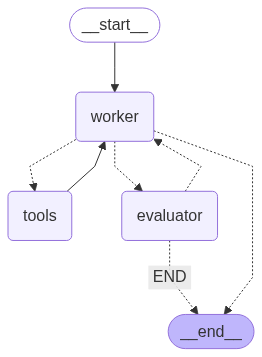

In [12]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
def make_thread_id() -> str:
    return str(uuid.uuid4())


async def process_message(message, success_criteria, history, thread):

    config = {"configurable": {"thread_id": thread}}

    state = {
        "messages": message,
        "success_criteria": success_criteria,
        "feedback_on_work": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }
    result = await graph.ainvoke(state, config=config)
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": result["messages"][-2].content}
    feedback = {"role": "assistant", "content": result["messages"][-1].content}
    return history + [user, reply, feedback]

async def reset():
    return "", "", None, make_thread_id()



In [14]:
# Esto evita el error: There is no current event loop in thread 'MainThread'
import uvicorn

uvicorn.config.LOOP_SETUPS = {
    "none": None,
    "auto": "uvicorn.loops.asyncio:asyncio_setup",
    "asyncio": "uvicorn.loops.asyncio:asyncio_setup",
    "uvloop": "uvicorn.loops.uvloop:uvloop_setup",
}

In [15]:
with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Sidekick Personal Co-worker")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        chatbot = gr.Chatbot(label="Sidekick", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to your sidekick")
        with gr.Row():
            success_criteria = gr.Textbox(show_label=False, placeholder="What are your success critiera?")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    message.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    success_criteria.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, success_criteria, chatbot, thread])

    
demo.launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
